In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
import SenseEmb
import SenseEmb.sense_vec_hdim as shdim

In [4]:
import json
from tqdm.auto import tqdm

In [5]:
import numpy.linalg as la
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist, squareform

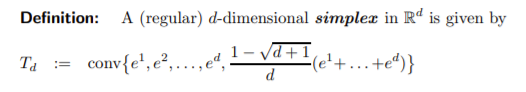

In [117]:
def get_n_simplex(n, s=1):
    coords = np.zeros(shape=(n+1, n))
    for i in range(n):
        coords[i][i] = 1
    coords[n] = (1-np.sqrt(n+1))/n * np.ones(n)
    return (coords-coords.mean(0))/np.sqrt(2) * s

In [116]:
coords = get_n_simplex_2(3, 2)
print(squareform(pdist(coords)))
print(coords.mean(0))

[[0. 2. 2. 2.]
 [2. 0. 2. 2.]
 [2. 2. 0. 2.]
 [2. 2. 2. 0.]]
[-5.55111512e-17 -5.55111512e-17 -2.77555756e-17]


In [118]:
coords = get_n_simplex(3)
coords.shape

(4, 3)

In [119]:
from scipy.spatial.distance import pdist, squareform
squareform(pdist(coords))

array([[0., 1., 1., 1.],
       [1., 0., 1., 1.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.]])

In [120]:
coords.mean(0)

array([-2.77555756e-17, -2.77555756e-17, -1.38777878e-17])

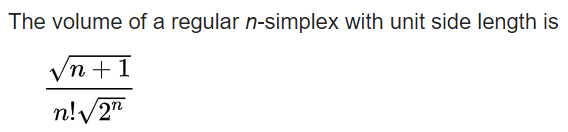

In [253]:
def n_simplex_volume(n, s=1, log=False):    
    if log:
        return (n*np.log(s) + 
                0.5*np.log(n+1) - 
                np.log(np.arange(1,n+1)).sum() - 
                n/2*np.log(2))
    else:
        return np.sqrt(n+1)*(s**n) / (np.math.factorial(n) * np.sqrt(2**n))
        

In [267]:
n=100;s=1
n_simplex_volume(n, s, log=True)

-396.08917432514016

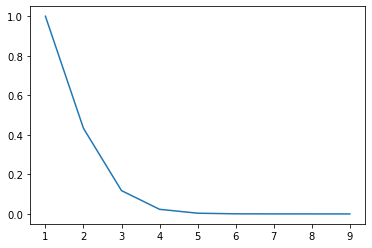

In [235]:
ks = np.arange(1,10)
plt.plot(ks, [n_simplex_volume(x, 1) for x in ks])

In [122]:
ConvexHull(coords).volume, n_simplex_volume(3, 1)

(0.11785113019775788, 0.1178511301977579)

## Determinant sandbox

In [20]:
A = np.random.uniform(size=(5,5))
la.det(A)
B = np.random.uniform(size=(10, 5))
np.sqrt(la.det(B.T.dot(B)))

0.9304611743495632

## Try simplex-hull on senses

In [21]:
from sklearn.decomposition import PCA

In [22]:
sdata = skv.make_sense_vectors("條")

In [139]:
svecs = sdata.sense_vecs
proj_svecs = PCA(13).fit_transform(svecs)
n_sense = proj_svecs.shape[0]
n_dim = proj_svecs.shape[1]
simplex_points = []
reg_nsimplex = get_n_simplex(n_dim)
for i in range(n_sense)[:3]:
    sense_nsimplex = reg_nsimplex + proj_svecs[i, :]
    simplex_points.extend(sense_nsimplex)
simplex_points = np.vstack(simplex_points)

In [ ]:
time.now

In [165]:
from time import time
from tqdm.auto import tqdm

ks = np.arange(2, 12)
ns = np.arange(20, 60, step=10)
time_metrics = np.zeros((len(ns), len(ks)))
for ki in tqdm(range(len(ks))):
    for ni in range(len(ns)):        
        n = ns[ni]; k = ks[ki]
        points = np.random.uniform(size=(n, k))
        t0 = time()
        hull = ConvexHull(points)
        t1 = time()
        time_metrics[ni, ki] = t1-t0
    

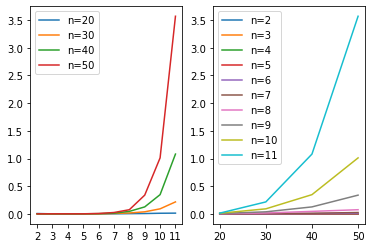

In [174]:
from matplotlib import pyplot as plt
_, axes = plt.subplots(1, 2)
for i in range(time_metrics.shape[0]):
    axes[0].plot(time_metrics[i, :], label=f"n={ns[i]}")
axes[0].set_xticks(np.arange(len(ks)))
axes[0].set_xticklabels([str(x) for x in ks])
axes[0].legend()

for j in range(time_metrics.shape[1]):
    axes[1].plot(time_metrics[:, j], label=f"n={ks[j]}")
axes[1].set_xticks(np.arange(len(ns)))
axes[1].set_xticklabels([str(x) for x in ns])
axes[1].legend()

In [140]:
%%time
hull = ConvexHull(simplex_points)
print("single simplex volume: ", n_simplex_volume(simplex_points.shape[1], 1))
print("convex hull volume: ", hull.volume)
print(simplex_points.shape, len(hull.vertices))

single simplex volume:  6.638786919642894e-12
convex hull volume:  1.108920696785342e-09
(42, 13) 42
Wall time: 415 ms


In [144]:
%%time
import scipy.spatial.qhull
_Qhull = scipy.spatial.qhull._Qhull
qhull = _Qhull(b"i", simplex_points, b"", required_options=b"",
                       incremental=False)
print("single simplex volume: ", n_simplex_volume(simplex_points.shape[1], 1))
print("convex hull volume: ", qhull.volume_area()[0])
print(simplex_points.shape, len(qhull.get_hull_points()))

single simplex volume:  6.638786919642894e-12
convex hull volume:  1.1089206967853292e-09
(42, 13) 42
Wall time: 167 ms


190

Wall time: 1min 15s


In [88]:
qhull.volume_area()

(0.21727007577832963, 2.922612419009036)

* 2D: 57 points, 1.03ms, vertices: 9
* 3D: 76 points, 1.97ms, vertices: 25
* 4D: 95 points, 2.00ms, vertices: 46
* 5D: 114 points, 7.95ms, vertices: 75
* 6D: 133 points, 47.8ms, vertices: 103
* 7D: 152 points, 491.8ms, vertices: 132
* 8D: 171 points, 10.8s, vertices: 159, w/o Qt: 2.98s
* 9D: 190 points, 276s,  vertics: 182, w/o Qt: 75s

## Compute highdim indices

In [14]:
skv = SenseEmb.SenseKeyedVectors.load_from_kv("../data/sense-emb-asbc5-600k-d50.kv")

In [6]:
shdim.compute_highdim_indices("條", skv)

條 (19, 3)


{'word': '條',
 'n_sense': 19,
 'sense_freqs': [62,
  2,
  279,
  6,
  138,
  4,
  76,
  26,
  7,
  75,
  27,
  48,
  49,
  482,
  3,
  129,
  193,
  8,
  5],
 'sv_cut': 2,
 'sv_ratio': 0.9015689,
 'hull': <scipy.spatial.qhull.ConvexHull at 0x16fa93c4490>,
 'voronoi': <scipy.spatial.qhull.Voronoi at 0x16fa93aa250>,
 'sense_vols': array([       inf,        inf,        inf, 0.05643899,        inf,
        0.10023888,        inf, 1.17399549,        inf,        inf,
        0.00846644, 0.01488769, 0.00325225,        inf,        inf,
               inf,        inf, 0.0686654 ,        inf]),
 'hull_vol': 0.20634410695815691,
 'in_open_region': [0, 1, 2, 4, 6, 8, 9, 13, 14, 15, 16, 18],
 'all_regions_volume': 1.4259451435509916,
 'clutsers': [{'vol_ratio': 0.04779825097428371,
   'senses': [('06585903', '0. [06585903]計算形狀細而長的物體的單位。: '),
    ('06585906', '2. [06585906]計算地面上長條型的建築物或自然景觀的單位。: 外有一<條>河，很'),
    ('06585907', '3. [06585907]計算流體的單位。: 發現這<條>噴射流'),
    ('06585908', '4. [06585908]計算動物的單位

In [7]:
with open("../data/sense_counts_monoword.json", "r", encoding="UTF-8") as fin:
    sense_counts = json.load(fin)

In [9]:
hdim_results = {}
for word, nsense in tqdm(sense_counts.items()):    
    if nsense < 4: continue
    result = shdim.compute_highdim_indices(word, skv)
    if result:
        hdim_results[word] = result

一 (9, 3)
丁 (3, 2)
Exceptino when computing community of word  丁
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
三 (3, 2)
上 (38, 5)
下

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


 (48, 5)
世 (7, 2)
丘 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

丟 (5, 2)
中 (33, 5)
串 (6, 3)
丹 (3, 2)
Exceptino when computing community of word  丹
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
主 (10, 3)
之 (5, 2)
乍 (3, 2)
Exceptino when computing community of word  乍
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
乎 (5, 2)
乏 (3, 2)
Exceptino when computing community of word  乏
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
乘 (9, 3)
乙 (3, 2)
Exceptino when computing community of word  乙
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
也 (15, 5)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

乾 (10, 3)
亂 (7, 3)
了 (5, 3)
予 (4, 2)
事 (6, 3)
于 (8, 3)
云 (4, 2)
井 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 52 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\si

交 (7, 3)
亦 (4, 2)
享 (3, 2)
Exceptino when computing community of word  享
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
亮 (12, 4)
人 (10, 4)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.util

今 (3, 2)
他 (4, 2)
付 (3, 2)
Exceptino when computing community of word  付
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
仙 (3, 2)
Exceptino when computing community of word  仙
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
代 (11, 4)
令

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider

 (5, 2)
以 (12, 5)
仰 (5, 2)
件 (9, 4)
任 (5, 3)
份 (7, 3)
仿 (3, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.p

Exceptino when computing community of word  仿
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
伊 (4, 2)
伍 (4, 2)
休 (3, 2)
Exceptino when computing community of word  休
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
伴 (4, 2)
似 (6, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


但 (3, 2)
位 (8, 4)
低 (12, 4)
佔 (8, 3)
何 (4, 2)
佛 (6, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might conside

作 (18, 5)
你 (4, 2)
使 (7, 3)
來 (18, 5)
例 (4, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

供 (7, 3)
依 (9, 3)
侵 (3, 2)
便 (13, 5)
保 (6, 2)
信 (6, 3)
修 (16, 5)
個 (9, 4)
倒 (12, 4)
倚 (4, 2)
借 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 22 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_

Exceptino when computing community of word  借
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
值 (5, 2)
假 (13, 4)
偏 (7, 3)
做 (20, 5)
停 (8, 3)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 32 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


偷 (3, 2)
Exceptino when computing community of word  偷
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
傘 (5, 2)
備 (4, 2)
催 (3, 2)
Exceptino when computing community of word  催
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
傳 (16, 4)
傷 (8, 3)
傻 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might conside

Exceptino when computing community of word  傻
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
傾 (3, 2)
Exceptino when computing community of word  傾
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
像 (5, 2)
優 (3, 2)
Exceptino when computing community of word  優
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
元 (4, 2)
充 (5, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 42 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

先 (5, 3)
光 (8, 4)
免 (4, 2)
兒 (5, 2)
兔 (3, 2)
Exceptino when computing community of word  兔
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
入 (15, 3)
內 (9, 4)
全 (6, 4)
兩 (5, 3)
公 (12, 4)
共 (4, 2)
兵 (5, 2)
其 (3, 2)
Exceptino when computing community of word  其
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
具 (7, 3)
兼 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.p

再 (6, 3)
冠 (4, 2)
冰 (3, 2)
Exceptino when computing community of word  冰
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
冷 (10, 4)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 24 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_

出 (17, 4)
刀 (5, 3)
分 (24, 5)
切 (9, 4)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


列 (7, 3)
初 (4, 2)
別 (6, 3)
利 (9, 4)
刮 (3, 2)
Exceptino when computing community of word  刮
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 20 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_

到 (10, 4)
制 (5, 3)
刷 (5, 2)
刺 (7, 2)
刻 (4, 2)
則 (4, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

前 (17, 5)
剛 (3, 2)
Exceptino when computing community of word  剛
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
剝 (3, 2)
剪 (4, 2)
副 (5, 2)
割 (3, 2)
Exceptino when computing community of word  割
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
創 (10, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

劑 (4, 2)
力 (4, 2)
功 (8, 4)
加 (11, 4)
勁 (3, 2)
Exceptino when computing community of word  勁
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
勇 (3, 2)
Exceptino when computing community of word  勇
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
動

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has 

 (14, 4)
勝 (3, 2)
Exceptino when computing community of word  勝
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
勞 (5, 3)
勢 (6, 2)
勾 (4, 2)
包 (13, 4)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

化 (9, 3)
北 (5, 2)
升 (6, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 22 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

半 (4, 2)
南 (4, 2)
博 (3, 2)
Exceptino when computing community of word  博
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
占 (6, 2)
卡 (8, 5)
印 (10, 4)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


危 (4, 2)
即 (10, 4)
卷 (9, 2)
厚 (5, 2)
原 (4, 2)
去 (19, 5)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.

參 (5, 3)
又 (8, 4)
叉 (3, 2)
Exceptino when computing community of word  叉
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
反 (8, 3)
取 (18, 4)
受 (6, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 22 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.ut

叢 (4, 2)
口 (13, 4)
古 (5, 3)
另 (4, 2)
叩 (4, 2)
只 (7, 3)
叫 (12, 4)
可 (8, 4)
台 (7, 3)
史 (4, 2)
右 (5, 2)
吃 (17, 5)
合 (8, 4)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


吊 (6, 2)
同 (9, 4)
名 (14, 4)
后 (6, 3)
吐 (6, 2)
向 (6, 3)
君 (5, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It ha

吧 (6, 2)
吳 (3, 2)
Exceptino when computing community of word  吳
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
吶 (5, 3)
吸 (10, 3)
吹 (8, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

呀 (13, 3)
呆 (4, 3)
Exceptino when computing community of word  呆
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
告 (4, 2)
周 (7, 3)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


味 (6, 2)
呵 (5, 2)
呼 (5, 2)
命 (6, 3)
和 (16, 5)
咧

../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: Run

 (4, 2)
咬 (6, 2)
品 (4, 2)
哇 (11, 2)
哈 (7, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might conside

哎 (3, 2)
Exceptino when computing community of word  哎
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
員 (4, 2)
哥 (4, 2)
哦 (5, 2)
哪 (10, 4)
唐 (5, 2)
唱 (3, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

唷 (4, 2)
唸 (5, 2)
商 (9, 3)
啊 (12, 3)
啟 (5, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

啥 (5, 3)
啦 (6, 2)
啪 (3, 2)
Exceptino when computing community of word  啪
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
善 (6, 3)
喊 (7, 3)
喔 (7, 2)
喘 (4, 2)
喚 (4, 2)
喝 (4, 2)
喪 (3, 2)
Exceptino when computing community of word  喪
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
單 (4, 2)
喲 (3, 2)
Exceptino when computing community of word  喲
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might conside

喻 (3, 2)
Exceptino when computing community of word  喻
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
嗯 (4, 2)
嘗 (4, 2)
嘴 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider

嘿 (3, 2)
Exceptino when computing community of word  嘿
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
器 (4, 2)
噸 (3, 2)
嚴 (3, 2)
Exceptino when computing community of word  嚴
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
回 (12, 5)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider 

固 (3, 2)
Exceptino when computing community of word  固
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
圈 (11, 4)
國 (5, 3)
圍 (4, 2)
園 (4, 2)
圓 (5, 2)
圖 (4, 2)
團 (7, 2)
土 (5, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

在 (10, 4)
地 (5, 4)
Exceptino when computing community of word  地
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
均 (3, 2)
坐 (7, 3)
坑 (3, 2)
Exceptino when computing community of word  坑
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
埋 (5, 2)
城 (6, 3)
基 (4, 2)
堂 (7, 3)
堅 (4, 2)
堆 (5, 3)
報 (9, 3)
場 (11, 4)
塊 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

塞 (6, 2)
填 (5, 2)
境 (4, 2)
墊 (5, 3)
墨 (5, 2)
壁 (3, 2)
Exceptino when computing community of word  壁
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
壓 (13, 4)
壞 (9, 3)
士 (5, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

壯 (5, 2)
壹 (4, 2)
壺 (4, 2)
夏 (6, 2)
外 (10, 4)
多 (7, 5)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

大 (17, 5)
天 (11, 4)
夫 (6, 2)
失 (8, 3)
夾 (8, 2)
奇 (5, 2)
奉 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.ut

奔 (3, 2)
套 (9, 4)
奪 (4, 2)
女 (3, 2)
Exceptino when computing community of word  女
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
奶 (3, 2)
Exceptino when computing community of word  奶
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

好 (15, 5)
如 (5, 3)
妙 (3, 2)
Exceptino when computing community of word  妙
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
妹 (4, 2)
姊 (4, 2)
姐 (3, 2)
Exceptino when computing community of word  姐
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
姑 (4, 3)
Exceptino when computing community of word  姑
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
姿 (3, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

Exceptino when computing community of word  姿
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
威 (3, 2)
Exceptino when computing community of word  威
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
娘 (5, 3)
媽 (4, 2)
嫌 (4, 3)
嫩 (4, 2)
子 (10, 4)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

孔 (4, 2)
字 (8, 3)
存 (7, 3)
季 (5, 2)
孤 (3, 2)
孫 (5, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

學 (9, 4)
守 (5, 2)
安 (8, 3)
宋 (7, 2)
完 (3, 2)
Exceptino when computing community of word  完
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
宗 (3, 2)
Exceptino when computing community of word  宗
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
官 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.util

定 (11, 3)
客 (7, 4)
室 (5, 3)
宮 (4, 2)
宰 (4, 2)
害 (6, 3)
家 (16, 5)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

容 (7, 3)
寄 (4, 2)
密 (5, 2)
富 (4, 2)
寒 (5, 2)
實 (6, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


寫 (8, 3)
寬 (4, 2)
寶 (4, 2)
寸 (5, 2)
寺 (3, 2)
Exceptino when computing community of word  寺
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
封 (7, 3)
射 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It ha

將 (8, 3)
專 (5, 3)
尊 (4, 2)
對 (18, 5)
小 (8, 3)
少 (8, 4)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

尖 (3, 2)
Exceptino when computing community of word  尖
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
尚 (4, 3)
尤 (3, 2)
Exceptino when computing community of word  尤
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
就 (22, 5)
尾 (4, 2)
局 (6, 3)
居 (6, 3)
展 (5, 2)
層 (11, 4)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


峰 (3, 2)
Exceptino when computing community of word  峰
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
島 (3, 2)
Exceptino when computing community of word  島
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
崩 (4, 2)
工 (7, 3)
左 (6, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider

差 (7, 3)
巴 (5, 3)
市 (3, 2)
Exceptino when computing community of word  市
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 28 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

帝 (3, 2)
Exceptino when computing community of word  帝
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
帥 (3, 2)
Exceptino when computing community of word  帥
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
師 (6, 2)
席 (6, 3)
帳 (5, 3)
帶 (20, 5)
常 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 22 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

Exceptino when computing community of word  常
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
幅 (4, 2)
幕 (4, 3)
幫 (4, 2)
平 (12, 5)
年

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: Run

 (8, 3)
幹 (9, 4)
幼 (4, 2)
幾 (4, 2)
床 (3, 2)
Exceptino when computing community of word  床
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


底 (11, 4)
府 (6, 2)
度 (14, 5)
座 (6, 2)
廟 (3, 2)
Exceptino when computing community of word  廟
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
廠 (5, 2)
廢 (5, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

廣 (8, 4)
延 (5, 4)
Exceptino when computing community of word  延
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
建 (5, 2)
弄 (6, 2)
式 (8, 4)
弓 (5, 2)
引

../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 26 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

 (7, 3)
弟 (4, 2)
弦 (6, 3)
弱 (6, 2)
張 (7, 3)
強 (10, 3)
彈 (6, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

彎 (6, 2)
形 (5, 2)
彩 (3, 2)
Exceptino when computing community of word  彩
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
影 (7, 2)
役 (4, 2)
往 (5, 2)
待 (7, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has

後 (17, 5)
徒 (3, 2)
Exceptino when computing community of word  徒
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
得 (13, 5)
從 (13, 5)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It ha

復 (4, 2)
微 (4, 2)
徵 (5, 3)
德 (7, 2)
心 (9, 4)
忙 (3, 2)
Exceptino when computing community of word  忙
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 28 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider

快 (6, 2)
念 (7, 3)
怕 (3, 2)
Exceptino when computing community of word  怕
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
急 (8, 3)
性 (5, 2)
息 (6, 3)
恰 (3, 2)
Exceptino when computing community of word  恰
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
悶 (6, 3)
情 (8, 2)
惡 (4, 2)
想

../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 20 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

 (9, 4)
意 (6, 2)
愛 (16, 5)
感 (3, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

應 (8, 4)
懷 (7, 4)
懸 (6, 3)
戀 (3, 2)
Exceptino when computing community of word  戀
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
成 (16, 5)
戒 (5, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 40 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 20 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.ut

或 (4, 3)
Exceptino when computing community of word  或
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
截 (3, 2)
Exceptino when computing community of word  截
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
戰 (9, 4)
戲 (3, 2)
Exceptino when computing community of word  戲
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
戳 (3, 2)
Exceptino when computing community of word  戳
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
戴 (5, 2)
戶

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 4 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 46 edges.
It has fully disconnected 1 vertices.
You might conside

 (5, 2)
房 (8, 3)
所 (6, 3)
扇 (4, 2)
手 (5, 3)
才 (10, 4)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It ha

扒 (3, 2)
Exceptino when computing community of word  扒
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
打 (73, 5)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


托 (7, 3)
扣 (5, 2)
扭 (4, 2)
扮 (3, 2)
Exceptino when computing community of word  扮
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
扯 (7, 3)
扶 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.util

批 (5, 2)
找 (4, 2)
抄 (5, 3)
把 (12, 3)
抓 (8, 3)
投

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

 (15, 4)
抖 (3, 2)
Exceptino when computing community of word  抖
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
抗 (4, 3)
Exceptino when computing community of word  抗
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
折 (6, 3)
披 (4, 2)
抬 (3, 2)
抱 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 4 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 24 edges.
It has fully disconnected 2 vertices.
You might conside

抵 (5, 3)
抹 (4, 2)
押 (5, 3)
抽 (15, 5)
拆 (5, 2)
拉 (12, 4)
拋 (5, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.ut

拍 (10, 4)
拐 (6, 3)
拔 (3, 2)
Exceptino when computing community of word  拔
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
拖 (8, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 24 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 40 edges.
It has fully disconnected 1 vertices.
You might conside

招 (11, 3)
拜 (8, 2)
拳 (4, 2)
拼 (4, 3)
拿 (11, 4)
持 (6, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 28 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

指 (7, 3)
按 (8, 3)
挑 (9, 4)
挖 (5, 2)
挨 (6, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

振 (3, 2)
Exceptino when computing community of word  振
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
挺 (5, 3)
挾 (7, 3)
捉 (6, 3)
捏 (5, 2)
捧 (5, 4)
Exceptino when computing community of word  捧
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 24 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.ut

捨 (4, 2)
捲 (7, 2)
掃 (5, 2)
掉 (12, 4)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 26 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might conside

掌 (7, 2)
排 (15, 4)
掘 (3, 2)
Exceptino when computing community of word  掘
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
掛 (10, 4)
採 (5, 2)
探 (7, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

接 (15, 3)
推 (8, 4)
掩 (3, 2)
提 (11, 4)
插 (7, 2)
揚 (5, 2)
換 (5, 2)
揮 (4, 2)
搏 (3, 2)
Exceptino when computing community of word  搏
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
搖 (5, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

搬 (3, 2)
Exceptino when computing community of word  搬
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
搭 (12, 5)
搶 (7, 3)
摔 (7, 2)
摘 (3, 2)
Exceptino when computing community of word  摘
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 32 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


摸 (11, 4)
摻 (3, 2)
Exceptino when computing community of word  摻
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
撈 (4, 2)
撐 (6, 2)
撒 (5, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might conside

撥 (6, 3)
播 (3, 2)
Exceptino when computing community of word  播
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
撲 (6, 3)
擁 (6, 2)
擊 (3, 2)
擋 (4, 3)
Exceptino when computing community of word  擋
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

操 (9, 4)
擔 (5, 3)
據 (7, 4)
擠 (5, 3)
擦 (5, 2)
擱 (4, 3)
Exceptino when computing community of word  擱
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
擺 (9, 4)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.ut

攏 (5, 3)
攜 (4, 2)
攤 (6, 3)
支 (10, 3)
收 (16, 4)
改 (7, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 22 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 28 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_

攻 (7, 3)
放 (34, 5)
故 (8, 4)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

救 (5, 3)
敗 (3, 2)
Exceptino when computing community of word  敗
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
教 (6, 2)
散 (9, 3)
敬 (4, 3)
Exceptino when computing community of word  敬
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
整 (5, 3)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 4 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has

敵 (4, 2)
數 (8, 4)
文 (11, 3)
料 (8, 3)
斜 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 20 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_

新 (6, 4)
斷 (6, 2)
方 (10, 4)
於 (10, 5)
施 (8, 3)
旁 (3, 2)
Exceptino when computing community of word  旁
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
旅

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

 (4, 2)
族 (4, 2)
日 (7, 3)
早 (12, 4)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might conside

旺 (5, 2)
明 (9, 3)
昏 (3, 2)
Exceptino when computing community of word  昏
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
易 (5, 2)
星 (7, 3)
春 (6, 2)
是 (6, 3)
時

../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has

 (10, 5)
晃 (5, 3)
晉 (3, 2)
Exceptino when computing community of word  晉
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
晒 (4, 2)
晚 (9, 3)
景 (4, 3)
Exceptino when computing community of word  景
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
暗 (8, 2)
曉 (3, 2)
Exceptino when computing community of word  曉
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
曰 (5, 2)
曲 (6, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 22 edges.
It has fully disconnected 2 vertices.
You might conside

書 (6, 3)
會 (10, 5)
月 (5, 3)
有 (8, 4)
服 (3, 2)
Exceptino when computing community of word  服
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
望 (5, 3)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 38 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

朝 (11, 4)
期 (7, 3)
木 (3, 2)
Exceptino when computing community of word  木
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
末 (5, 2)
本 (18, 5)
朱 (3, 2)
Exceptino when computing community of word  朱
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

材 (4, 2)
村 (4, 2)
杯 (3, 2)
Exceptino when computing community of word  杯
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
東 (4, 2)
板 (4, 2)
枕

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

 (3, 2)
Exceptino when computing community of word  枕
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
林 (5, 3)
枚 (5, 2)
果 (6, 3)
枯 (4, 2)
架 (6, 3)
柄 (3, 2)
Exceptino when computing community of word  柄
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 24 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_

染 (4, 2)
柔 (3, 2)
Exceptino when computing community of word  柔
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
查 (3, 2)
Exceptino when computing community of word  查
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
柱 (4, 2)
校 (4, 2)
核 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider

Exceptino when computing community of word  核
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
根 (8, 3)
格 (6, 3)
栽 (5, 3)
框 (3, 2)
Exceptino when computing community of word  框
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
案 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has

桌 (7, 2)
桿 (6, 2)
梅 (3, 2)
Exceptino when computing community of word  梅
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
條 (19, 3)
梯 (4, 2)
棄 (5, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 22 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 1 vertices.
You might conside

棋 (4, 2)
棒 (5, 3)
業 (7, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

槍 (7, 3)
樂 (6, 2)
樑 (4, 2)
標 (6, 3)
樣 (6, 3)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


樹 (3, 2)
Exceptino when computing community of word  樹
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
橋 (6, 3)
機 (4, 2)
橫 (6, 2)
檔 (9, 3)
檢 (3, 2)
Exceptino when computing community of word  檢
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

欄 (4, 2)
欠 (4, 2)
次 (4, 2)
欲 (5, 3)
欸 (5, 2)
款 (6, 3)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It ha

歌 (4, 2)
止 (5, 2)
正 (18, 5)
步 (5, 2)
歪 (3, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


Exceptino when computing community of word  歪
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
歷 (3, 2)
Exceptino when computing community of word  歷
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
歸 (10, 3)
死 (13, 3)
殆 (3, 2)
Exceptino when computing community of word  殆
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
殘 (3, 2)
段 (7, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider 

殺 (6, 2)
殼 (4, 3)
毀 (3, 2)
Exceptino when computing community of word  毀
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
母 (7, 3)
毒 (8, 4)
比 (12, 5)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

毛 (8, 3)
民 (6, 3)
氣 (7, 3)
水 (7, 3)
求 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 36 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_

江 (5, 3)
池 (3, 2)
Exceptino when computing community of word  池
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
汪 (3, 2)
Exceptino when computing community of word  汪
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
沈 (4, 3)
Exceptino when computing community of word  沈
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
沉 (5, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 4 vertices.
You might consider

沒 (6, 3)
沖 (3, 2)
Exceptino when computing community of word  沖
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
沙 (4, 3)
Exceptino when computing community of word  沙
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
油 (8, 3)
治 (6, 3)
沾 (5, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 24 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

泉 (3, 2)
Exceptino when computing community of word  泉
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
法 (9, 4)
泛 (4, 2)
泡 (5, 2)
波 (6, 2)
注 (3, 3)
Exception when computing geometry of word  注
QH6214 qhull input error: not enough points(3) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1998403967  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0



c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might conside

洋 (3, 2)
洗 (3, 2)
Exceptino when computing community of word  洗
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
洩 (4, 3)
Exceptino when computing community of word  洩
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
活 (10, 4)
派 (5, 3)
流 (9, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertice

浮 (3, 2)
海 (5, 3)
消 (7, 4)
涼 (5, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

淡 (7, 2)
淨 (5, 3)
深 (10, 3)
混 (8, 3)
淺 (7, 3)
添 (6, 3)
清 (18, 5)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 24 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.ut

減 (4, 2)
渡 (3, 2)
Exceptino when computing community of word  渡
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
游 (3, 2)
湊 (3, 2)
Exceptino when computing community of word  湊
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

湧 (3, 2)
Exceptino when computing community of word  湧
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
湯 (6, 3)
源 (3, 2)
Exceptino when computing community of word  源
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
準 (7, 4)
溜 (3, 2)
溝 (3, 2)
Exceptino when computing community of word  溝
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
溫 (6, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 22 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

溼 (4, 2)
滅 (5, 2)
滴 (5, 2)
滾

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


 (8, 3)
滿 (5, 3)
漆 (4, 2)
演 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

漢 (8, 3)
漲 (5, 2)
潔 (4, 2)
潮 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

澳 (4, 2)
濃 (8, 2)
濕 (5, 2)
灌 (6, 3)
灑 (4, 2)
灘 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might conside

火 (5, 2)
灶 (3, 2)
Exceptino when computing community of word  灶
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
災 (3, 2)
Exceptino when computing community of word  災
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
炒 (5, 2)
炭 (3, 2)
Exceptino when computing community of word  炭
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
炮 (7, 3)
炸 

../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_sc

(3, 2)
Exceptino when computing community of word  炸
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
為 (8, 3)
烈 (5, 2)
烙 (3, 3)
Exception when computing geometry of word  烙
QH6214 qhull input error: not enough points(3) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1998437581  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

烤 (4, 2)
焉 (3, 2)
Exceptino when computing community of word  焉
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
無 (4, 2)
焦 

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_sc

(4, 2)
然 (4, 2)
煞 (3, 2)
Exceptino when computing community of word  煞
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
照 (15, 3)
煩 (4, 3)
Exceptino when computing community of word  煩
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
熄 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 4 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

熟 (6, 2)
熱 (12, 3)
燒 (7, 2)
燙 (5, 2)
營 (4, 3)
Exceptino when computing community of word  營
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 4 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might conside

爆 (3, 2)
Exceptino when computing community of word  爆
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
爛 (6, 2)
爪 (3, 2)
Exceptino when computing community of word  爪
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
爬 (7, 3)
爸 (4, 2)
爽 (3, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertice

Exceptino when computing community of word  爽
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
片 (17, 3)
版 (3, 2)
Exceptino when computing community of word  版
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
牌 (8, 3)
牛 (6, 4)
牢 (4, 3)
Exceptino when computing community of word  牢
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 4 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

物 (4, 2)
特 (6, 3)
牽 (7, 3)
犯 (9, 3)
狀 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

狗 (4, 2)
狠 (3, 2)
Exceptino when computing community of word  狠
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
猛 (7, 2)
猴 (4, 2)
猶 (3, 2)
Exceptino when computing community of word  猶
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
獨 (3, 2)
Exceptino when computing community of word  獨
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
獵 (3, 2)
Exceptino when computing community of word  獵
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
率 (3, 2)
Exceptino when computing community of word  率
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
王 (7, 3)
玩 (8, 3)
珠

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider 

 (3, 2)
Exceptino when computing community of word  珠
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
班 (13, 4)
現 (6, 2)
球 (6, 2)
理 (10, 4)
琴 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

環 (6, 3)
瓦 (3, 2)
Exceptino when computing community of word  瓦
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
瓶 (3, 2)
Exceptino when computing community of word  瓶
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
甚 (4, 3)
甜 (5, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider

生 (24, 5)
產 (6, 2)
用 (13, 5)
甩 (4, 2)
田 (3, 2)
Exceptino when computing community of word  田
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
由 (12, 5)
甲 (3, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

Exceptino when computing community of word  甲
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
男 (4, 2)
界 (5, 4)
留 (10, 4)
畝 (3, 2)
Exceptino when computing community of word  畝
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
略 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

番 (8, 3)
畫 (10, 4)
當 (12, 5)
疊 (5, 3)
疏 (4, 2)
病 (5, 3)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

瘋 (3, 2)
Exceptino when computing community of word  瘋
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
瘦 (5, 2)
癡 (3, 2)
Exceptino when computing community of word  癡
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
登 (6, 3)
發 (26, 5)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 20 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:125: UserWarning: A few of your vertices were d

白 (12, 4)
的 (10, 5)
皮 (5, 3)
益 (3, 2)
Exceptino when computing community of word  益
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
盛 (3, 2)
Exceptino when computing community of word  盛
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

盜 (4, 3)
盡 (5, 3)
盤 (9, 3)
盪 (3, 2)
Exceptino when computing community of word  盪
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
目 (3, 2)
Exceptino when computing community of word  目
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
盲 (3, 2)
Exceptino when computing community of word  盲
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider 

直 (11, 2)
相 (7, 3)
省 (8, 4)
眉 (3, 2)
Exceptino when computing community of word  眉
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
看 (13, 5)
真 (11, 3)
眼 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.util

睡 (9, 3)
瞎 (3, 2)
Exceptino when computing community of word  瞎
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
知 (7, 2)
短 (9, 4)
矮 (4, 2)
石 (3, 2)
Exceptino when computing community of word  石
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

砲 (4, 2)
破 (15, 5)
砸 (3, 2)
硬 (11, 3)
碎 (3, 2)
Exceptino when computing community of word  碎
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
碰 (8, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 36 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 20 edges.
It has fully disconnected 1 vertices.
You might conside

碼 (6, 2)
磨 (6, 3)
示 (4, 2)
神 (8, 3)
票 (7, 4)
祭 (4, 2)
禮 (4, 2)
禿 (3, 2)
Exceptino when computing community of word  禿
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
秀 (7, 3)
私

../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

 (5, 2)
秋 (4, 3)
Exceptino when computing community of word  秋
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
科 (7, 3)
秦 (4, 2)
移

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 4 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

 (8, 3)
稀 (5, 3)
稍 (3, 2)
Exceptino when computing community of word  稍
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
種 (9, 4)
稱 (5, 2)
穩 (6, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


空 (25, 5)
穿 (3, 2)
Exceptino when computing community of word  穿
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
窄 (3, 2)
Exceptino when computing community of word  窄
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
窗 (3, 3)
Exception when computing geometry of word  窗
QH6214 qhull input error: not enough points(3) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1998521616  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

窩 (4, 2)
窮 (4, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider 

窺 (3, 2)
立 (14, 4)
站 (7, 3)
章 (5, 2)
端 (9, 3)
竹 (3, 2)
Exceptino when computing community of word  竹
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
竿 (3, 2)
Exceptino when computing community of word  竿
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has 

符 (4, 2)
笨 (7, 2)
筆 (8, 3)
等 (8, 4)
算 (9, 3)
管 (12, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 36 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.ut

箭 (4, 2)
箱 (4, 2)
節 (4, 2)
築 (4, 3)
籃 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

籠 (3, 2)
Exceptino when computing community of word  籠
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
籤 (3, 2)
Exceptino when computing community of word  籤
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
米 (4, 3)
Exceptino when computing community of word  米
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
粉 (3, 2)
粒 (3, 2)
粗 (6, 3)
精 (6, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 4 vertices.
You might consider

糟 (3, 2)
Exceptino when computing community of word  糟
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
系 (3, 2)
Exceptino when computing community of word  系
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
約 (8, 4)
紅 (7, 3)
納 (3, 2)
Exceptino when computing community of word  納
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider 

紙 (3, 2)
Exceptino when computing community of word  紙
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
級 (4, 2)
細 (8, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


組 (6, 2)
結 (8, 3)
絕 (7, 3)
給 (7, 3)
絲 (9, 2)
綁 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


經 (12, 4)
綠 (5, 3)
維 (3, 2)
Exceptino when computing community of word  維
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
網 (11, 4)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

緊 (7, 2)
線 (19, 4)
緣 (7, 4)
編 (7, 3)
緩 (4, 2)
練 (3, 2)
Exceptino when computing community of word  練
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
縫 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 34 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

Exceptino when computing community of word  縫
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
縮 (6, 3)
縱 (7, 3)
總 (7, 3)
繞 (6, 2)
繫 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

繼 (3, 2)
Exceptino when computing community of word  繼
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
纏 (4, 2)
缺 (5, 3)
罪 (4, 2)
置 (5, 2)
署 (3, 2)
Exceptino when computing community of word  署
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertice

罷 (4, 2)
羊 (5, 3)
美 (5, 2)
群 (6, 3)
義 (6, 2)
羽

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertice

 (3, 2)
習 (3, 2)
Exceptino when computing community of word  習
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
翹 (5, 2)
翻 (14, 3)
老 (12, 5)
考 (4, 3)
Exceptino when computing community of word  考
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
而 (10, 5)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

耍 (5, 2)
耳 (5, 3)
聖 (4, 2)
聞 (4, 2)
聯 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

聲 (4, 2)
聽 (4, 2)
肉 (4, 2)
肚 (5, 2)
股 (9, 3)
肥 (8, 3)
肩 (5, 3)
背 (13, 4)
胎 (3, 2)
Exceptino when computing community of word  胎
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
胖 (4, 2)
胡 (3, 2)
Exceptino when computing community of word  胡
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
胸 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 38 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

能 (5, 3)
脆 (3, 2)
Exceptino when computing community of word  脆
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
脈 (4, 2)
脫 (8, 3)
脹 (3, 2)
Exceptino when computing community of word  脹
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
腔

../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertice

 (3, 2)
Exceptino when computing community of word  腔
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
腦 (5, 3)
腰 (4, 2)
腳 (7, 3)
腹 (3, 2)
Exceptino when computing community of word  腹
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
腿 (3, 2)
Exceptino when computing community of word  腿
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_sc

膽 (4, 2)
臣 (3, 2)
Exceptino when computing community of word  臣
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
臥 (3, 2)
臨 (7, 3)
自 (6, 3)
臭 (3, 2)
Exceptino when computing community of word  臭
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
至 (5, 3)
致 (4, 3)

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertice


臺 (5, 3)
與 (6, 4)
舉 (4, 2)
舊 (6, 3)
舞

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 24 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_

 (4, 2)
色 (8, 2)
花 (9, 4)
苗 (4, 2)
苦 (10, 3)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


茶 (4, 2)
草 (4, 2)
荒 (3, 2)
Exceptino when computing community of word  荒
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
菜 (6, 4)
華

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.util

 (5, 2)
萬 (4, 2)
落 (17, 4)
葉 (8, 4)
著 (8, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has

葬 (3, 2)
蒙 (4, 2)
蒸 (3, 2)
蓋 (8, 3)
蓮 (3, 2)
Exceptino when computing community of word  蓮
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has 

蔣 (3, 2)
Exceptino when computing community of word  蔣
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
薄 (6, 2)
藍 (5, 2)
藏 (7, 3)
蘇 (6, 3)
虎 (5, 2)
處 (9, 4)
虛 (5, 2)
號 (6, 2)
虧 (5, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.ut

蛇 (4, 3)
Exceptino when computing community of word  蛇
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
蛋 (3, 2)
Exceptino when computing community of word  蛋
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
融 (3, 2)
Exceptino when computing community of word  融
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
蠱 (3, 2)
蠻 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertice

Exceptino when computing community of word  蠻
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
血 (3, 2)
Exceptino when computing community of word  血
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
行 (20, 5)
術 (3, 2)
Exceptino when computing community of word  術
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
衝 (6, 2)
衣 (3, 2)
Exceptino when computing community of word  衣
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
表 (11, 5)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_sc

袋 (3, 2)
Exceptino when computing community of word  袋
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
裂 (3, 2)
裏 (3, 2)
Exceptino when computing community of word  裏
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
補 (11, 4)
裝 (6, 3)
裡 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 20 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

製 (3, 2)
Exceptino when computing community of word  製
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
西 (7, 3)
要 (12, 5)
覆 (4, 2)
見 (8, 4)
親 

../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

(7, 3)
覺 (5, 2)
觀 (3, 2)
Exceptino when computing community of word  觀
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
角 (11, 4)
解 (14, 4)
觸 (4, 2)
言 (8, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 34 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 24 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consid

訂 (6, 3)
計 (5, 3)
討 (5, 3)
記 (9, 3)
訪 (4, 2)
設 (7, 2)
許 (4, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 4 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

Exceptino when computing community of word  許
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
評 (3, 2)
Exceptino when computing community of word  評
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
詞 (6, 2)
試 (6, 3)
該 (4, 3)
Exceptino when computing community of word  該
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
認 (9, 4)
語 (8, 3)
誤 (5, 3)
說 (12, 5)
課 (6, 4)
調 (14, 5)
談 (3, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: Runt

請 (7, 3)
論 (5, 3)
謀 (3, 2)
Exceptino when computing community of word  謀
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
謂 (9, 2)
講 (12, 4)
證

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

 (4, 2)
識 (4, 2)
譜 (5, 2)
護 (3, 2)
Exceptino when computing community of word  護
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
讀 (6, 3)
變 (4, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 24 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

讓 (6, 3)
豆 (3, 2)
Exceptino when computing community of word  豆
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
象

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

 (5, 3)
豬 (4, 3)
貌 (4, 2)
負 (7, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

貫 (3, 2)
Exceptino when computing community of word  貫
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
貴 (6, 3)
貶 (3, 2)
貼 (5, 2)
資 (4, 2)
賊 (3, 2)
Exceptino when computing community of word  賊
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

賞 (5, 3)
賠 (3, 2)
質 (3, 2)
Exceptino when computing community of word  質
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
賬 (3, 2)
Exceptino when computing community of word  賬
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
賴 (5, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider

走 (16, 5)
起 (25, 5)
超 (3, 2)
Exceptino when computing community of word  超
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
越 (3, 2)
趕 (10, 4)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_sc

足 (6, 3)
趴 (3, 2)
Exceptino when computing community of word  趴
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
跌 (3, 2)
Exceptino when computing community of word  跌
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
跑 (9, 3)
距 (4, 2)
跟 (11, 4)
跨 (6, 3)
路 (7, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 22 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

跳 (13, 5)
踏 (6, 2)
踩 (4, 2)
蹲 (5, 2)
躍 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might conside

身 (5, 2)
躺 (4, 2)
車 (7, 3)
軍 (6, 2)
軟 (5, 3)
軸 (3, 2)
Exceptino when computing community of word  軸
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
載

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

 (7, 3)
輕 (13, 4)
輩 (4, 3)
Exceptino when computing community of word  輩
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
輪 (7, 3)
輸 (4, 2)
轉 (19, 5)
辣 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

辦 (6, 3)
辭 (5, 3)
農 (4, 2)
近 (8, 4)
迷 (5, 3)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


追 (9, 4)
退 (8, 2)
送 (12, 4)
透 (9, 3)
逐 (4, 2)
途 (3, 2)
Exceptino when computing community of word  途
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider 

逗 (3, 2)
Exceptino when computing community of word  逗
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
這 (7, 3)
通 (10, 3)
逝 (5, 2)
造 (9, 3)
連 (10, 4)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.uti

進 (14, 5)
逼 (4, 2)
逾 (3, 2)
Exceptino when computing community of word  逾
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
遊 (5, 2)
運 (7, 3)
遍 (3, 2)
Exceptino when computing community of word  遍
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
過 (13, 5)
道 (17, 5)
達 (5, 3)
遠 (4, 2)
適 (4, 3)
Exceptino when computing community of word  適
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 18 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It ha

遲 (5, 2)
選 (5, 3)
避 (3, 2)
Exceptino when computing community of word  避
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
還 (10, 4)
邊 (13, 5)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


那 (10, 5)
部 (9, 4)
都 (5, 3)
鄉 (4, 2)
鄭 (3, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.util

鄰 (6, 4)
配 (14, 3)
酸 (5, 2)
醉 (6, 3)
醒 (4, 2)
醜 (3, 2)
Exceptino when computing community of word  醜
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertice

醫 (8, 3)
釋 (4, 2)
重 (17, 5)
野 (4, 2)
量 (6, 2)
金 (10, 2)
釘 (4, 2)
針 (8, 3)
鈴 (4, 2)
銀 (4, 2)
銅 (5, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 36 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might conside

銷 (3, 2)
Exceptino when computing community of word  銷
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
鋪 (5, 2)
錄 (3, 2)
Exceptino when computing community of word  錄
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
錢 (8, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider

錯 (6, 3)
鎖 (8, 4)
鎮 (3, 2)
鐘 (4, 2)
鐵 (5, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 24 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

鑽 (6, 3)
長 (21, 5)
門 (15, 4)
閃 (7, 2)
閉 (4, 2)
開 (62, 5)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 20 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has

閒 (4, 2)
間 (10, 4)
閩 (3, 2)
Exceptino when computing community of word  閩
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
闊 (3, 2)
Exceptino when computing community of word  闊
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
闖 (5, 2)
關 (15, 4)
闢 (3, 2)
Exceptino when computing community of word  闢
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

防 (4, 2)
附 (4, 2)
降 (13, 4)
陣 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

除 (4, 2)
陰 (6, 2)
陳 (5, 2)
陷 (4, 2)
陸 (4, 2)
陽 (5, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 22 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

隊 (4, 2)
隔 (7, 3)
隨 (7, 3)
險 (3, 2)
Exceptino when computing community of word  險
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
隱 (4, 3)
Exceptino when computing community of word  隱
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.util

隻 (5, 2)
雄 (4, 2)
集 (5, 3)
雙 (3, 2)
雞 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consid

離 (5, 3)
難 (3, 2)
雲 (5, 2)
零 (3, 2)
Exceptino when computing community of word  零
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
電 (6, 2)
震 (6, 2)
露 (4, 2)
霸 (3, 2)
Exceptino when computing community of word  霸
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
靈 (7, 3)
青 (9, 2)
靜 (6, 3)
非 (6, 3)
靠 (10, 3)
面 (11, 3)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 8 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertice

韓 (5, 3)
響 (7, 2)
頂 (9, 3)
頃 (3, 2)
Exceptino when computing community of word  頃
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
項 (3, 2)
順 (6, 2)
頓 (4, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 16 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertic

領 (6, 2)
頭 (17, 5)
題 (6, 4)
顏 (3, 2)
Exceptino when computing community of word  顏
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
類 (4, 2)
顧 (3, 2)
Exceptino when computing community of word  顧
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 22 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 22 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_

顯 (7, 3)
風 (6, 3)
飄 (5, 2)
飛 (6, 3)
食 (7, 2)
飯 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 24 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your verti

飲 (3, 2)
飽 (5, 2)
餅 (5, 2)
養 (8, 4)
餘 (5, 3)
館 (6, 3)
餵 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 14 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_s

Exceptino when computing community of word  餵
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
饒 (3, 2)
Exceptino when computing community of word  饒
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
首 (7, 3)
香 (5, 2)
馬 (12, 4)
驅 (3, 2)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 4 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertice

Exceptino when computing community of word  驅
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
驚 (3, 2)
骨 (3, 2)
髒 (4, 2)
體 (8, 4)
高 (19, 5)
鬆 (8, 4)
鬥 (4, 2)


../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 20 edges.
It has fully disconnected 1 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_

鬧 (6, 2)
鬼 (4, 2)
魂 (3, 2)
Exceptino when computing community of word  魂
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
魏 (3, 2)
Exceptino when computing community of word  魏
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
魔 (3, 2)
Exceptino when computing community of word  魔
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
鮮 (5, 2)
鳳 (3, 2)
Exceptino when computing community of word  鳳
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
鳴 (4, 2)
麵 (5, 2)
麻 (4, 2)
黃 (8, 4)


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 10 edges.
It has fully disconnected 1 vertices.
You might conside

黏 (4, 3)
Exceptino when computing community of word  黏
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
黑 (13, 4)
點 (22, 5)
鼓 (8, 3)
鼠 (3, 2)
Exceptino when computing community of word  鼠
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value


c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 12 edges.
It has fully disconnected 4 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider

齡 (3, 2)
Exceptino when computing community of word  齡
Error at src\_igraph\attributes.c:1427: No such attribute. -- Invalid value
龍 (12, 4)



../src\SenseEmb\sense_vec_hdim.py:60: RuntimeWarning: invalid value encountered in double_scalars
  vol_ratio = volume_clust/all_regions_volume


In [18]:
shdim.compute_highdim_indices("丁", skv)

c:\python38\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 6 edges.
It has fully disconnected 3 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


> e:\langon\senseemb\src\senseemb\sense_vec_hdim.py(50)compute_community()
-> g2 = ig.Graph.Weighted_Adjacency(graph.todense(), mode="undirected")


(Pdb)  graph


<3x3 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Compressed Sparse Row format>


(Pdb)  graph.todense()


matrix([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=float32)


(Pdb)  q


BdbQuit: 

In [19]:
skv.make_sense_vectors("丁")

SenseData(sense_ids=['05153502', '05153503', '06044201'], sense_labels=['[05153502]同類事物中等級排在第四的。: 、丙、<丁>四等。', '[05153503]同類事物中順序排在第四的。: ', '[06044201]姓。: 期六，<丁>伯伯來'], sense_freqs=[10, 7, 14], sense_vecs=array([[ 0.06995423,  0.0208891 , -0.08738308,  0.04665702,  0.02791651,
        -0.07307541,  0.02600583,  0.13643742, -0.23107062, -0.14046054,
        -0.20171718, -0.06155344,  0.22114106, -0.12822573, -0.18729556,
         0.10965383,  0.05530892,  0.03789277, -0.35189468, -0.13566639,
        -0.06844223,  0.3311261 ,  0.10178883, -0.1339178 , -0.03558215,
         0.14417861, -0.10505204, -0.05502537, -0.37424335,  0.08118462,
        -0.12759937, -0.01466005, -0.06938801,  0.06904054, -0.15054032,
        -0.08491372, -0.01424735,  0.08260404, -0.02318053, -0.05607383,
         0.21367466,  0.03077446, -0.27015197,  0.08686365,  0.20639695,
        -0.01837869, -0.08128795, -0.07121514,  0.06774616,  0.06541903],
       [ 0.0834071 ,  0.01448654, -0.01889644,  0.06141088,  0.156